# **IMDB 리뷰 데이터셋**

- 유명한 인터넷 영화 데이터베이스인 imdb.com 에서 수집한 리뷰를 감상평에 따라 긍정과 부정으로 분류해 놓은 말뭉치

## 자연어 처리(natural language processing, NLP)

- 컴퓨터를 사용해 인간의 언어를 처리하는 분야
- 세부 분야
    - 음성 인식
    - 기계 번역
    - 감성 분석
- 자연어 처리 분야에서는 훈련 데이터를 말뭉치(corpus)라고 부름

## 임베딩

- 사람이 쓰는 자연어를 기계가 이해할 수 있는 숫자의 나열인 벡터로 바꾼 결과 혹은 그 과정 전체
- 컴퓨터에서 처리하는 모든 것은 숫자로 이루어진 데이터
    - 따라서 텍스트 그 자체를 신경망에 전달하지 않음
    - 합성곱 신경망에서 이미지를 다룰 때는 이미지가 정수 픽셀값으로 이루어져 있어서 특별히 변환을 하지 않음
- 텍스트 임베딩의 가장 쉬운 방법은 데이터에 등장하는 단어마다 고유한 정수를 부여하는 것
    - 예)
        - he : 10
        - follows : 11
        - the : 12
        - cat : 13
    - 단어에 매핑되는 정수는 단어의 의미나 크기와 관련이 없음
        - He를 10으로 매핑하고 cat을 13에 매핑하더라도 cat이 He 보다 좋거나 크다는 뜻이 아님
    - 정수 중 몇 가지는 특정한 용도로 예약되어 있는 경우가 많음
        - 예) 0 : 패딩, 1 : 문장의 시작, 2 : 어휘 사전에 없는 토큰
            - 어휘 사전 : 훈련 세트에서 고유한 단어를 뽑아 만든 목록 
- 일반적으로 영어 문장은 모두 소문자로 바꾸고 구둣점을 삭제한 다음 공백을 기준으로 분리
    - 이렇게 분리된 단어를 토큰(token)이라고 부름
        - 하나의 샘플은 여러 개의 토큰으로 이루어져 있고 이 때 하나의 토큰이 하나의 타임스텝에 해당
    - 영어 말뭉치에서 토큰은 단어와 같이 취급하는 경우가 많음
        - 한국어는 조사가 발달되어 있어 공백으로 나누는 것만으로는 부족함
            - 일반적으로 한글은 형태소 분석을 통해 토큰을 분리

# **원핫 인코딩을 활용한 RNN 텍스트 분류**

## 1. 데이터 준비

In [10]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

In [11]:
# num_words : 단어 빈도가 많은 순서로 num_words 만큼 보존
# 전체 데이터셋에서 가장 자주 등장하는 단어 500개만 사용
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = 500)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
# 훈련 세트, 테스트 세트의 크기 확인
print(x_train.shape, x_test.shape)

(25000,) (25000,)


In [16]:
# 리뷰의 길이 출력
print(len(x_train[0]), len(x_train[1]))

218 189


- 각각 25000개의 샘플로 이루어져 있음
- 텍스트 길이가 제각각임
    - 고정 크기의 2차원 배열에 담는 것 보다 리뷰마다 별도의 파이썬 리스트로 담아야 메모리를 효율적으로 사용할 수 있음

In [19]:
# 첫 번째 리뷰 출력
print(x_train[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [21]:
# 타깃 데이터 출력
# 0 : 부정, 1 : 긍정
print(y_train[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [23]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size = 0.2,
                                                  stratify = y_train, 
                                                  random_state = 26)

In [25]:
print(x_train.shape, x_val.shape)

(20000,) (5000,)


### - 각 리뷰의 길이 확인

- 각 리뷰의 길이를 넘파이 배열로 담아 평균 리뷰 길이, 길이 최솟값, 길이 최댓값을 확인

In [28]:
lengths = np.array([len(x) for x in x_train])

In [30]:
# 길이 평균값과 중간값
print(np.mean(lengths), np.median(lengths), np.min(lengths), np.max(lengths))

238.5516 178.0 11 2494


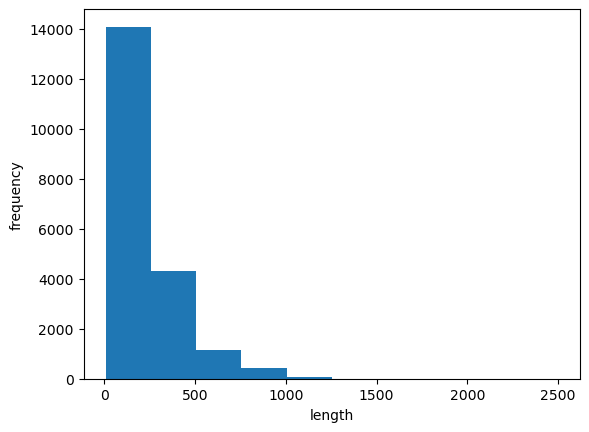

In [32]:
plt.figure()
plt.hist(lengths)

plt.xlabel("length")
plt.ylabel("frequency")
plt.show()

- 평균이 중간값보다 높은 이유는 아주 큰 데이터가 있기 때문
- 대부분의 리뷰는 짧기 때문에 이번 예제에서는 리뷰의 길이를 100에 맞춰서 사용
    - 100보다 짧은 리뷰는 길이를 100에 맞추기 위해 패딩이 필요
        - 패딩을 나타내는 토큰으로는 0을 사용

In [35]:
# x_train의 길이를 100으로 맞추기
train_seq = pad_sequences(x_train, maxlen = 100)

- maxlen 에 원하는 길이를 지정하면 그것보다 긴 경우는 잘라내고 짧은 경우는 0으로 패딩

In [38]:
# train_seq 크기 확인
print(train_seq.shape)

(20000, 100)


In [40]:
print(train_seq[0])

[101   2   2   7   2  89 196  26  75 424   8 264  15  84  70  30   2  11
   2   2   2   5 131   2   2   2   2   2   6  22  15 286   2  18 101 116
   2  33   4   2  13   6   2   2  11   2   5 117 334  10  10   4  64 282
  13   2  14  17   6   2   2   9  13  81  24   2   4   2   7 158   2   2
 291 154   2   2 451   2  57   2 216   8  27   2   5  13 244  24  66   2
  11   2   6   2   7   2  65 116  42   2]


In [42]:
print(x_train[0][-100:])

[101, 2, 2, 7, 2, 89, 196, 26, 75, 424, 8, 264, 15, 84, 70, 30, 2, 11, 2, 2, 2, 5, 131, 2, 2, 2, 2, 2, 6, 22, 15, 286, 2, 18, 101, 116, 2, 33, 4, 2, 13, 6, 2, 2, 11, 2, 5, 117, 334, 10, 10, 4, 64, 282, 13, 2, 14, 17, 6, 2, 2, 9, 13, 81, 24, 2, 4, 2, 7, 158, 2, 2, 291, 154, 2, 2, 451, 2, 57, 2, 216, 8, 27, 2, 5, 13, 244, 24, 66, 2, 11, 2, 6, 2, 7, 2, 65, 116, 42, 2]


- pad_sequences() 함수는 기본적으로 maxlen 보다 긴 시퀀스의 앞부분을 잘라냄
    - 일반적으로 시퀀스의 뒷부분의 정보가 더 유용하기 때문에
        - 리뷰 끝에 결정적인 소감을 말할 가능성이 높음
    - 시퀀스의 뒷부분을 잘라내고 싶다면
        - truncating 매개변수 값을 "post"로 변경
            - 기본값은 "pre"

In [45]:
print(train_seq[6])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   1  13  81 169  12   6 227   2 279  45  43
  88 207 115 110   6   2 310   2   2  21  13  43  92  79  83  12  40   6
 176   7  85  84  81   4   2   9  66  87 151  17   2   2   6   2   6 136
  15 299  11  61 419 175  58  13 140   2]


- 패딩 토큰은 시퀀스의 앞부분에 추가됨
    - 시퀀스의 마지막에 있는 단어가 셀의 은닉 상태에 가장 큰 영향을 미치게 되기 때문에
    - 뒷부분에 패딩을 추가하고 싶다면
        - padding 매개변수의 값을 "post"로 수정
            - 기본값은 "pre"

In [48]:
# 검증 세트의 길이를 100으로 맞추기
val_seq = pad_sequences(x_val, maxlen = 100)

## 2. 모델 구성

- 케라스의 SimpleRNN 클래스 사용
- 이진분류
    - 출력층은 1개의 유닛을 가지고 시그모이드 출력층 함수를 사용

In [51]:
model = keras.Sequential()
model.add(keras.Input(shape = (100, 500)))
model.add(keras.layers.SimpleRNN(8))
model.add(keras.layers.Dense(1, activation = "sigmoid"))

- 입력층
    - 입력 차원의 첫 번째 차원은 샘플의 길이
    - 입력 차원의 두 번째 차원은 고유한 단어 수
        - load_data() 함수에서 500개의 단어만 사용하도록 지정했기 때문에 이번 예제의 고유한 단어 수는 500
- SimpleRNN
    - 첫 번째 매개변수는 사용할 유닛의 개수
    - activation
        - 기본값은 "tanh"
            - 하이퍼볼릭 탄젠트
- 원핫인코딩을 사용하는 이유
    - 토큰을 정수로 변환한 데이터를 그대로 신경망에 주입하면 큰 정수가 큰 활성화 출력을 만듦
        - 정수 사이에는 어떤 관련도 없고 20번 토큰이 10번 토큰보다 중요한 것이 아님

In [54]:
# 케라스에서 제공하는 원핫 인코딩을 위한 함수
train_oh = keras.utils.to_categorical(train_seq)

In [55]:
print(train_oh.shape)

(20000, 100, 500)


In [58]:
print(train_oh[0, 0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [60]:
print(np.sum(train_oh[0, 0]))

1.0


- 하나의 원소만 1이고 나머지 원소는 모두 0임

In [63]:
# val_seq 원핫인코딩
val_oh = keras.utils.to_categorical(val_seq)

In [65]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)        │ (None, 8)             │        4,072 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense (Dense)                 │ (None, 1)             │            9 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 4,081 (15.94 KB)

 Trainable params: 4,081 (15.94 KB)

 Non-trainable params: 0 (0.00 B)

- SimpleRNN에 전달할 샘플의 크기는 (100, 500) 이지만 순환층은 마지막 타임스텝의 은닉 상태만 출력
    - 출력 크기가 순환층의 유닛 개수와 동일
- 파라미터 개수
    - 입력 토큰은 500차원의 원핫 인코딩 배열
    - 배열이 순환층의 유닛 8개와 완전 연결
        - 500 * 8 = 4000
    - 순환층의 은닉 상태는 다시 다음 타임스텝에 사용하기 위해 또 다른 가중치와 곱해짐
        - 은닉 상태 크기 * 유닛 개수
            - 8 * 8 = 64
    - 각 유닛마다 하나의 절편
        - 8
    - 4000 + 64 + 8 = 4072

## 3. 모델 훈련

In [69]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])

In [71]:
cp_cb = keras.callbacks.ModelCheckpoint("./model/best-simplernn-model.keras", save_best_only = True)
es_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)

In [73]:
history = model.fit(train_oh, y_train, epochs = 100, batch_size = 64,
                    validation_data = (val_oh, y_val), callbacks = [cp_cb, es_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.4954 - loss: 0.7015 - val_accuracy: 0.4938 - val_loss: 0.7008
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5171 - loss: 0.6948 - val_accuracy: 0.4984 - val_loss: 0.6976
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5172 - loss: 0.6939 - val_accuracy: 0.5140 - val_loss: 0.6931
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5422 - loss: 0.6884 - val_accuracy: 0.5466 - val_loss: 0.6856
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5789 - loss: 0.6789 - val_accuracy: 0.5886 - val_loss: 0.6757
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6154 - loss: 0.6687 - val_accuracy: 0.6260 - val_loss: 0.6647
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6444 - loss: 0.6574 - val_accuracy: 0.6508 - val_loss: 0.6526
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6618 - loss: 0.6449 -

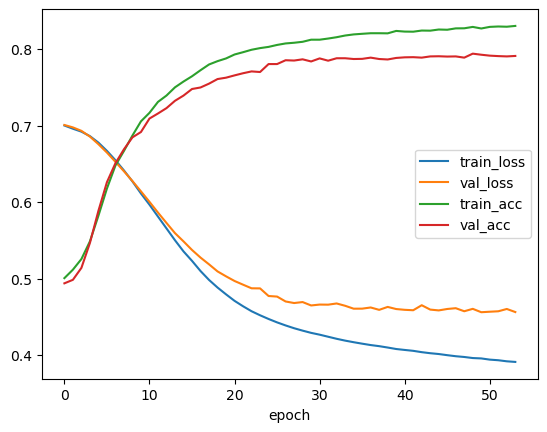

In [75]:
plt.figure()
plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.xlabel("epoch")
plt.legend()
plt.show()

- 원핫 인코딩의 단점
    - 입력 데이터가 매우 커짐

In [78]:
print(train_seq.nbytes, train_oh.nbytes)

8000000 8000000000
